# Project: AI-Driven Video Generation and Scene Understanding

The system generates videos from detailed descriptive prompts using Veo 2, then leverages Gemini Vision’s image-to-text API to analyze and verify the visual content of the generated videos.

### Workflow

**Video Generation**

- Input example: “A medieval castle under a thunderstorm, cinematic style”

- A LangChain agent enhances the prompt by adding parameters like camera angle, lighting, and style.

The refined prompt is sent to Veo 2, which produces the video (either hosted URL or downloadable clip).

**Scene Understanding**

- - Keyframes are extracted from the video using OpenCV’s cv2.VideoCapture.

Each keyframe is passed to Gemini Vision API to generate descriptive captions.

This pipeline verifies if the video content matches the input prompt by comparing AI-generated captions from keyframes.

## Setup Environment

This section installs required libraries and authenticates access to Google AI Studio APIs for Veo 2 (video generation) and Gemini Vision (image-to-text).


In [1]:
# Install necessary packages
!pip install --quiet google langchain opencv-python-headless

In [2]:
# Imports
from google.colab import userdata
import time
from google import genai
from google.genai import types

import cv2
import requests
import io
import os
from PIL import Image
import numpy as np
from typing import List, Tuple
from IPython.display import Video, display
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [4]:
client = genai.Client(api_key=GEMINI_API_KEY)

## Section 2: Tools & Pipeline Utilities

This section defines the core components for video generation and scene analysis.
We break the process into modular functions for:
- Text-to-video generation via Veo 2
- Keyframe extraction from video clips
- Image-to-text captioning using Gemini 2.5 Vision

The end goal is to verify whether the video content matches the original prompt through visual captioning.


### 2.1 Text-to-Video Generation via Veo 2

This function uses the official Veo API through `google.genai` to generate a 5-second video based on a descriptive prompt. The output is saved as an `.mp4` file locally in the Colab environment.


In [11]:
def generate_video_with_veo(prompt: str, output_path: str = "generated_video.mp4") -> str:
    """
    Generates a 5-second video using Veo 2.0 from a text prompt.
    """

    print(f"Prompt submitted: {prompt}")

    operation = client.models.generate_videos(
        model="veo-2.0-generate-001",
        prompt=prompt,
        config=types.GenerateVideosConfig(
            person_generation="dont_allow",
            aspect_ratio="16:9",
            duration_seconds=5,
        ),
    )

    # Print operation metadata immediately
    print("Initial operation object:")
    print(operation)

    # Wait for generation to complete
    while not operation.done:
        print("Generating video... please wait")
        time.sleep(20)
        operation = client.operations.get(operation)
        print("Updated operation status:")
        print(operation)

    # Debug: check response
    if not hasattr(operation, "response") or not operation.response:
        print("No response in operation:")
        print(operation)
        raise RuntimeError("Video generation failed: No response.")

    if not operation.response.generated_videos:
        print("Generated videos list is empty.")
        print("Full response:")
        print(operation.response)
        raise RuntimeError("Video generation failed: No output returned.")

    for n, generated_video in enumerate(operation.response.generated_videos):
        print(f"Downloading video #{n + 1}")
        client.files.download(file=generated_video.video)
        generated_video.video.save(output_path)
        print(f"Video saved to {output_path}")
        return output_path

    raise RuntimeError("Video generation failed: Loop completed with no return.")


### 2.2 Keyframe Extraction from Video Clips

Once the video is generated, we extract keyframes at fixed intervals using OpenCV. These frames will later be analyzed by Gemini Vision for image captioning.

We convert each frame to a `PIL.Image` so it's compatible with Gemini’s image-to-text API.


In [6]:
def extract_keyframes(video_path: str, frame_interval: int = 30) -> List[Image.Image]:
    """
    Extracts keyframes from a video at every `frame_interval` frames.

    Args:
        video_path (str): Path to the .mp4 video file.
        frame_interval (int): Number of frames to skip between each keyframe.

    Returns:
        List[PIL.Image]: List of RGB keyframes as PIL Images.
    """
    keyframes = []
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise IOError(f"Failed to open video: {video_path}")

    frame_count = 0
    while True:
        success, frame = cap.read()
        if not success:
            break

        if frame_count % frame_interval == 0:
            # Convert BGR (OpenCV) to RGB (PIL)
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(rgb_frame)
            keyframes.append(pil_image)

        frame_count += 1

    cap.release()
    print(f"Extracted {len(keyframes)} keyframes.")
    return keyframes


### 2.3 Image-to-Text Captioning using Gemini 2.5 Flash Lite

Each extracted video frame is passed to the Gemini Vision model (`gemini-2.5-flash-lite`) which generates a natural language caption for the image.

The model returns what it "sees" in the frame, helping us verify if the video matches the original prompt.


In [7]:
def get_caption_from_gemini(image: Image.Image) -> str:
    """
    Sends a PIL Image to Gemini 2.5 Flash Lite Vision model and returns a caption.

    Args:
        image (PIL.Image): An image to describe.

    Returns:
        str: Caption describing the image.
    """


    # Convert PIL image to bytes
    with io.BytesIO() as output:
        image.save(output, format="JPEG")
        image_bytes = output.getvalue()

    gemini_image = types.Part.from_bytes(
        data=image_bytes, mime_type="image/jpeg"
    )

    response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=[
        "Describe the image in exactly 10 words.",
        gemini_image
    ],
    # max_new_tokens=20  # Adjust token limit as needed # Removed as it's not a valid parameter
    )


    return response.text.strip()

### 2.4 Connecting the Pipeline

This function orchestrates the full flow — generating a video from a prompt, extracting keyframes, and captioning each frame using Gemini Vision. It returns all frame captions for analysis and verification.


In [8]:
def run_full_pipeline(prompt: str, frame_interval: int = 30, max_frames: int = 4):
    """
    Run the complete text-to-video-to-captions pipeline and display results in Colab.

    Args:
        prompt (str): Text prompt describing the video scene.
        frame_interval (int): Interval for keyframe extraction.
        max_frames (int): Maximum number of keyframes to display.

    Returns:
        List[Tuple[int, str]]: List of (frame_index, caption).
    """
    # Step 1: Generate video
    video_path = generate_video_with_veo(prompt)

    # Step 2: Extract keyframes
    frames = extract_keyframes(video_path, frame_interval)
    frames = frames[:max_frames]  # Limit to first few frames

    # Step 3: Generate captions
    captions = []
    for i, frame in enumerate(frames):
        caption = get_caption_from_gemini(frame)
        captions.append((i, caption))
        print(f"\nCaption: {caption}")

    # Step 4: Display Prompt
    display(HTML(f"<h3>Prompt:</h3><p>{prompt}</p>"))

    # Step 5: Display Video
    display(HTML("<h3>Generated Video:</h3>"))
    display(Video(video_path, embed=True))


    return captions


## Section 3: Running the Pipeline & Evaluation

In this section, we run the full pipeline on a sample prompt and evaluate how well the captions generated from the video keyframes match the original description.

We will:
- Run the pipeline end-to-end
- Display the keyframe captions
- Provide basic qualitative analysis (manual or automated)


In [ ]:
sample_prompt = "An office space, people are working"
video_path = generate_video_with_veo(sample_prompt)
display(Video(video_path, embed=True))

In [ ]:
keyframes = extract_keyframes(video_path, frame_interval=30)

Extracted 4 keyframes.


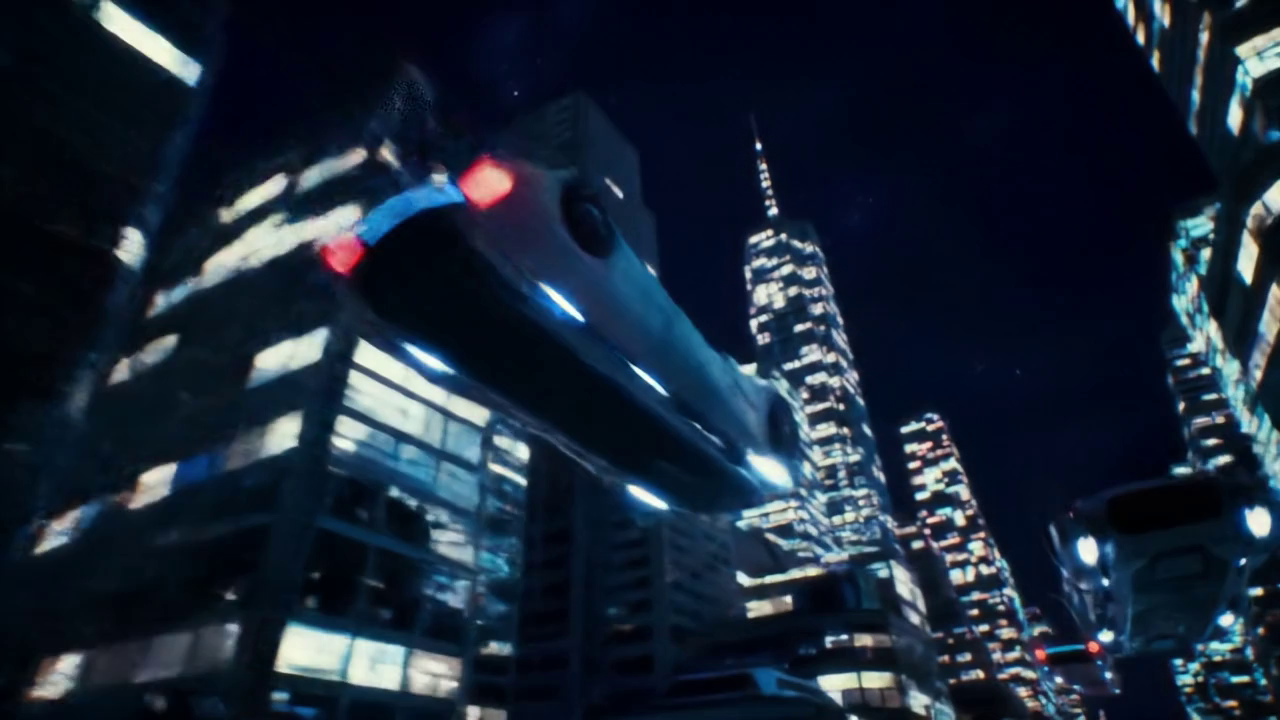


Prompt: A futuristic New York cityscape with flying cars at night, neon lights, cinematic tone
Caption: This image depicts a **futuristic cityscape at night**, characterized by:

1.  **Towering Skyscrapers:** Numerous tall, modern buildings dominate the scene, their windows brightly illuminated with a mix of white, yellow, and blue lights, creating a vibrant glow against the dark sky.
2.  **Flying Vehicles:**
    *   In the center, a **sleek, futuristic vehicle (likely a "flying car" or "hovercraft")** is prominent, appearing to glide or fly through the urban environment. It features bright blue under-lights and distinctive red lights at its rear, suggesting propulsion or taillights.
    *   Another similar flying vehicle is partially visible on the far right, further indicating a system of aerial transportation.
3.  **Night Sky:** The background is a dark night sky, with faint specks of light that could be stars, visible between the towering structures.
4.  **Atmosphere:** The overal

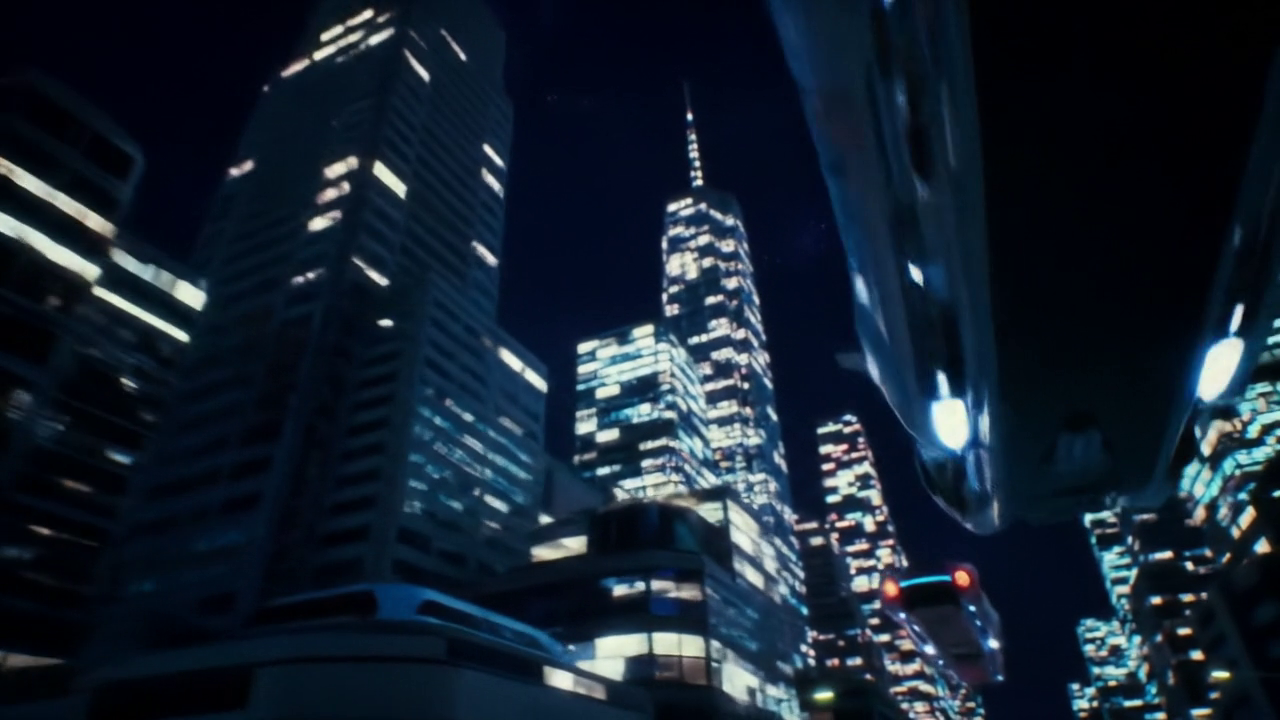


Prompt: A futuristic New York cityscape with flying cars at night, neon lights, cinematic tone
Caption: This image depicts a vibrant, futuristic cityscape at night.

Here's a breakdown of what's visible:

1.  **Skyscrapers and Buildings:** Numerous tall buildings and skyscrapers dominate the scene, stretching upwards against a dark night sky. Many of their windows are illuminated, creating a dazzling pattern of lights in various shades of white and blue.
2.  **Prominent Skyscraper:** Towards the center-right, a very tall, slender skyscraper with a distinctive pointed spire at its top stands out, heavily lit from within. Its design suggests modern architecture.
3.  **Flying Vehicles:**
    *   In the upper right quadrant, a large, sleek, and futuristic flying vehicle (possibly an airship, blimp, or large aircraft) is seen from its underside. It has bright lights along its belly.
    *   Further down and to the right, a smaller, car-like flying vehicle is visible, identifiable by its di

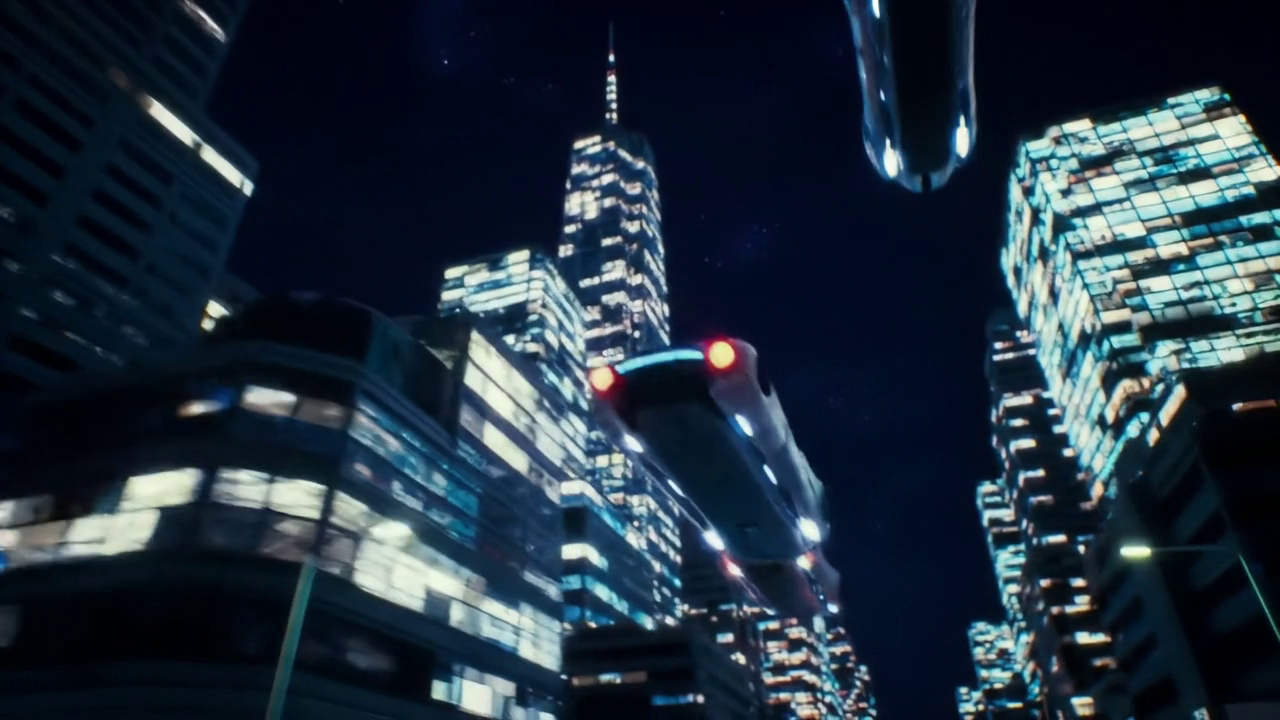


Prompt: A futuristic New York cityscape with flying cars at night, neon lights, cinematic tone
Caption: This image depicts a **futuristic city at night**, characterized by towering skyscrapers and flying vehicles, suggesting a science fiction setting.

Here's a breakdown of what's in the image:

1.  **Skyscrapers:** The scene is dominated by numerous tall, modern-looking buildings that reach high into the dark night sky. Many of their windows are illuminated with bright lights, creating patterns of glowing rectangles across their facades.
    *   On the left, there are several buildings with a mix of lit and dark windows, some appearing curved.
    *   In the center-background, a very tall, prominent skyscraper stands out, featuring a distinctive spire or antenna at its peak, heavily lit.
    *   On the right, another large building shows a distinct grid pattern of brightly lit windows, reflecting light with a cool, bluish hue.

2.  **Flying Vehicles:** Several flying objects are visi

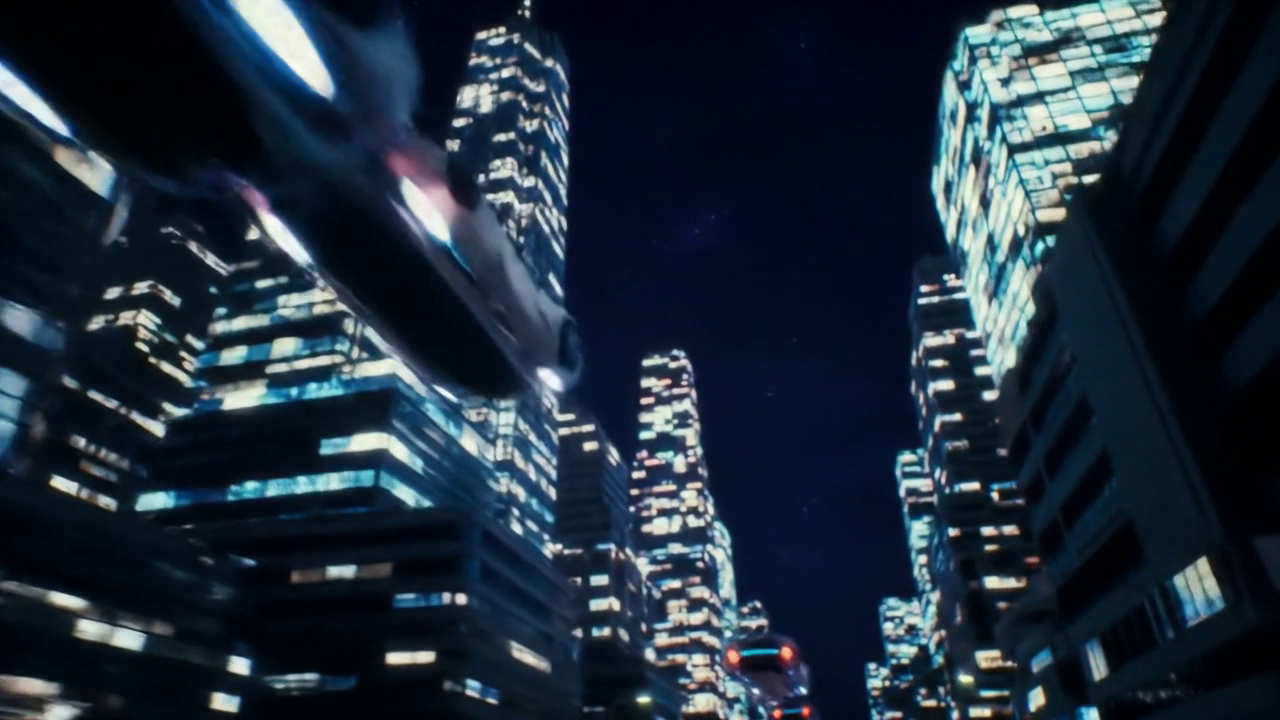


Prompt: A futuristic New York cityscape with flying cars at night, neon lights, cinematic tone
Caption: This image depicts a vibrant, **futuristic cityscape at night**, viewed from a low angle looking upwards.

Here's a breakdown of what's in the image:

1.  **Tall Buildings/Skyscrapers:** The scene is dominated by numerous high-rise buildings, likely skyscrapers, that stretch high into the dark sky. Their windows are brightly illuminated, creating a dazzling grid of light patterns across their facades. The light from the windows primarily appears as cool blue and white tones, with some warmer yellow hues.

2.  **Night Sky:** The background is a deep, dark blue or black, indicative of night. Faint, scattered white dots can be seen, suggesting stars or distant atmospheric lights.

3.  **Flying Vehicles:**
    *   **Prominent in the upper left:** A large, sleek, and somewhat blurred object is flying past. Its metallic surface reflects the city lights. It appears to be a futuristic aeria

In [ ]:
# Step 3: Get and print captions for keyframes
keyframe_captions = {}

for i, frame in enumerate(keyframes):
    caption = get_caption_from_gemini(frame)
    keyframe_captions[i] = caption
    display(frame)
    print(f"\nPrompt: {sample_prompt}\nCaption: {caption}")

In [13]:
from IPython.display import HTML

captions = run_full_pipeline(
    prompt="Ofice space with dogs working "


)

Prompt submitted: Ofice space with dogs working 
Initial operation object:
name='models/veo-2.0-generate-001/operations/61mnookgrpns' metadata=None done=None error=None response=None result=None
Generating video... please wait
Updated operation status:
name='models/veo-2.0-generate-001/operations/61mnookgrpns' metadata=None done=None error=None response=None result=None
Generating video... please wait
Updated operation status:
name='models/veo-2.0-generate-001/operations/61mnookgrpns' metadata=None done=True error=None response=GenerateVideosResponse(
  rai_media_filtered_count=2,
  rai_media_filtered_reasons=[
    'Your current safety settings for people/face generation filtered out 1 videos. You will not be charged for blocked videos. Try rephrasing the prompt. If you think this was an error, send feedback.',
    'Your current safety settings for people/face generation filtered out 1 videos. You will not be charged for blocked videos. Try rephrasing the prompt. If you think this was 

RuntimeError: Video generation failed: No output returned.

## Activity

Make a video of the current situation of the classroom.